In [1]:
import numpy as np
import scipy.signal
from scipy.optimize import minimize
import pandas as pd
pd.set_option('max_columns', None)
from sklearn import linear_model
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import seaborn as sns
import sys
import os
import fur.path_assistant as path_assistant
from fur.waveform_reader import read_waveform
from fur.finding_period import get_period
from fur.fluctuations import get_fluctiation_and_noise_var
from fur.one_data_set_analyzer import analyze_one_dataset
from fur.extending_with_acnet_data import get_fluctuations_df_with_acnet_data, get_acnet_df_with_bunch_sizes
shift = path_assistant.PathAssistant('shift_03_16_2020',
    ignore_files=['RefCurve_2020-03-16_0_084020_test.Wfm.bin',
                  'RefCurve_2020-03-16_153_155200.Wfm.bin'])
#shift_03_09_2020.show_waveform_file_names()
waveforms_dir = shift.get_waveforms_dir()
results_dir = shift.get_results_dir()
from config import get_from_config, save_to_config
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
import lattice.lattice as lattice

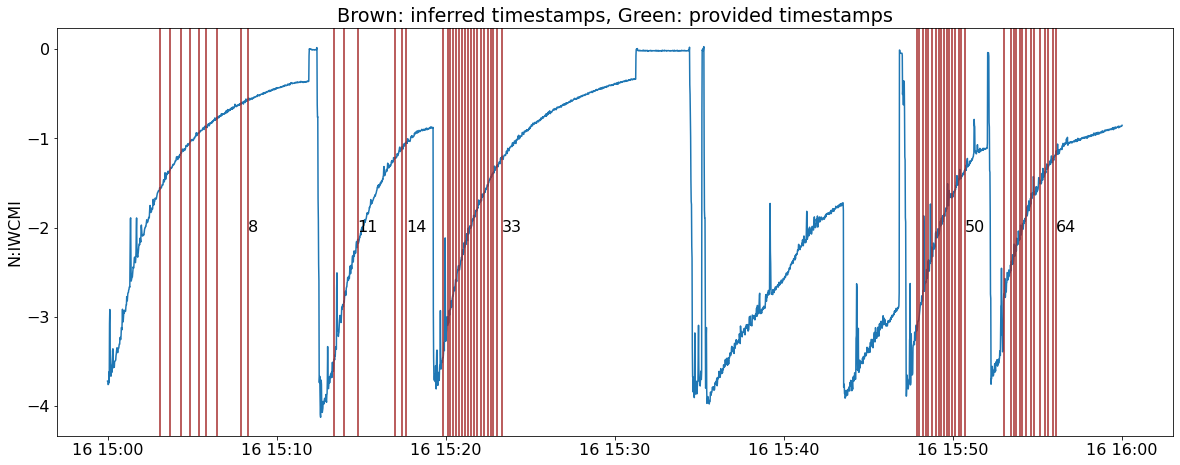

In [2]:
res_df_FLAT = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_FLAT_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"
)
acnted_df_FLAT = shift.get_acnet_data_df('all_acnet_data_FLAT_case_03_16_2020.csv')
res_df_ROUND = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_ROUND_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt",
    'all_acnet_data_ROUND_case_03_16_2020.csv',
    show_plot=False
)
acnted_df_ROUND = shift.get_acnet_data_df('all_acnet_data_ROUND_case_03_16_2020.csv')
res_df_ROUND_Low_RF = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_ROUND_LONG_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt",
    'all_acnet_data_ROUND_low_RF_case_03_16_2020.csv',
    show_plot=True
)
acnted_df_ROUND_Low_RF = shift.get_acnet_data_df('all_acnet_data_ROUND_low_RF_case_03_16_2020.csv')

In [3]:
rdt = res_df_ROUND_Low_RF['real_datetime']
time_intervals = [(rdt[0], rdt[8]), (rdt[9], rdt[14]), (rdt[15], rdt[33]), (rdt[34], rdt[50]), (rdt[51], rdt[64])]
def in_time_intervals(row):
    t = row.name
    return True in [(t>ti[0] and t<ti[1]) for ti in time_intervals]
time_intervals

[(Timestamp('2020-03-16 15:03:07'), Timestamp('2020-03-16 15:08:19')),
 (Timestamp('2020-03-16 15:13:22'), Timestamp('2020-03-16 15:17:40')),
 (Timestamp('2020-03-16 15:19:52'), Timestamp('2020-03-16 15:23:20')),
 (Timestamp('2020-03-16 15:47:52'), Timestamp('2020-03-16 15:50:41')),
 (Timestamp('2020-03-16 15:53:02'), Timestamp('2020-03-16 15:56:06'))]

In [4]:
cur_to_sum_channel = get_from_config("Beam_current_to_Sum_channel_ampl_V/mA")

In [5]:
sum_channel_to_photoelectrons = get_from_config('sum_channel_to_photoelectrons')

In [6]:
Mfunc, Mxder, Myder, Mzder, Meder = get_M_interpolator_at_fixed_energy()

In [7]:
size_names = ['Sigma_um_X', 'Sigma_um_Y', 'N:IWCMBE']
def var_theor(x, M):
    return x+1/M*x**2

In [8]:
for fluctuations_df in [res_df_FLAT, res_df_ROUND, res_df_ROUND_Low_RF]:
    N = sum_channel_to_photoelectrons*fluctuations_df["ch2_amplitude"].values
    varN = 2*sum_channel_to_photoelectrons**2*fluctuations_df["var_of_ch1_amplitude"].values
    fluctuations_df['N'] = N
    fluctuations_df['varN'] = varN
    fluctuations_df['varN_theor'] = fluctuations_df.apply(lambda row: var_theor(row['N'],Mfunc(row['Sigma_um_X'], row['Sigma_um_Y'], row['N:IWCMBE'])),axis=1) 

In [9]:
# plt.plot(res_df_FLAT["ch2_amplitude"],res_df_FLAT["var_of_ch1_amplitude"] ,'.', label="FLAT")
# plt.plot(res_df_ROUND["ch2_amplitude"],res_df_ROUND["var_of_ch1_amplitude"] ,'.', label="ROUND")
# plt.plot(res_df_ROUND_Low_RF["ch2_amplitude"],res_df_ROUND_Low_RF["var_of_ch1_amplitude"] ,'.', label="ROUND_LONG")
# x_f = np.linspace(0,max(res_df_FLAT["ch2_amplitude"]),1000)
# plt.xlabel("Sum channel amplitude, V")
# plt.ylabel("Variance of the difference channel amplitude, V$^2$")
# plt.title(r"Shift 03-16-2020")
# plt.legend()
# plt.savefig(results_dir.fi("no_nd_filters_variable_beam_current.png"), bbox_inches='tight')
# plt.show()

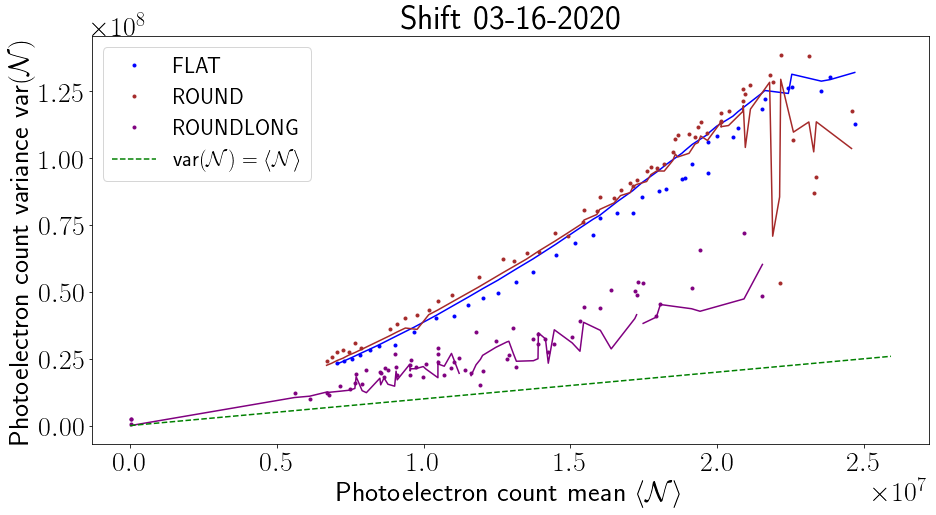

In [10]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
colors = {"FLAT": 'blue', "ROUND": 'brown', "ROUNDLONG": 'purple'}
data_sets = {'FLAT': res_df_FLAT, 'ROUND': res_df_ROUND ,'ROUNDLONG': res_df_ROUND_Low_RF}
fig, ax = plt.subplots(figsize=(15, 7.5))
for name, df in data_sets.items():
    ax.plot(
        df["N"],
        df["varN"],
        '.', label=name, color=colors[name])
    df_N_sorted = df.sort_values('N')
    ax.plot(
        df_N_sorted["N"],
        df_N_sorted["varN_theor"]
        ,'-', color=colors[name])
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
ax.set_title(r"Shift 03-16-2020")
ax.legend()
plt.show()

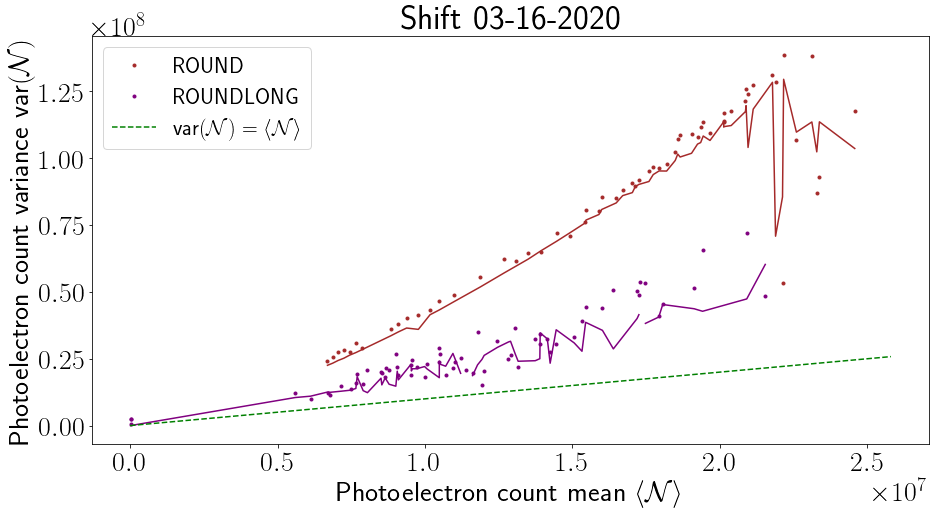

In [11]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
colors = {"ROUND": 'brown', "ROUNDLONG": 'purple'}
data_sets = {'ROUND': res_df_ROUND ,'ROUNDLONG': res_df_ROUND_Low_RF}
fig, ax = plt.subplots(figsize=(15, 7.5))
for name, df in data_sets.items():
    ax.plot(
        df["N"],
        df["varN"],
        '.', label=name, color=colors[name])
    df_N_sorted = df.sort_values('N')
    ax.plot(
        df_N_sorted["N"],
        df_N_sorted["varN_theor"]
        ,'-', color=colors[name])
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
ax.set_title(r"Shift 03-16-2020")
ax.legend()
plt.show()

In [12]:
# acnet_df_ROUND_LONG_with_bunch_sizes = get_acnet_df_with_bunch_sizes(
#     shift,
#     "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt",
#     acnted_df_ROUND_Low_RF
# )

In [13]:
# acnet_df_ROUND_LONG_with_bunch_sizes.to_csv(shift.get_acnet_data_dir().fi('all_acnet_data_with_bunch_sizes_ROUND_LONG_case_03_16_2020.csv'))

In [14]:
acnet_df_ROUND_LONG_with_bunch_sizes = pd.read_csv(shift.get_acnet_data_dir().fi('all_acnet_data_with_bunch_sizes_ROUND_LONG_case_03_16_2020.csv'), index_col=0, parse_dates=True)
acnet_df_ROUND_LONG_with_bunch_sizes_in_time_intervals = acnet_df_ROUND_LONG_with_bunch_sizes[acnet_df_ROUND_LONG_with_bunch_sizes.apply(in_time_intervals, axis=1).values]

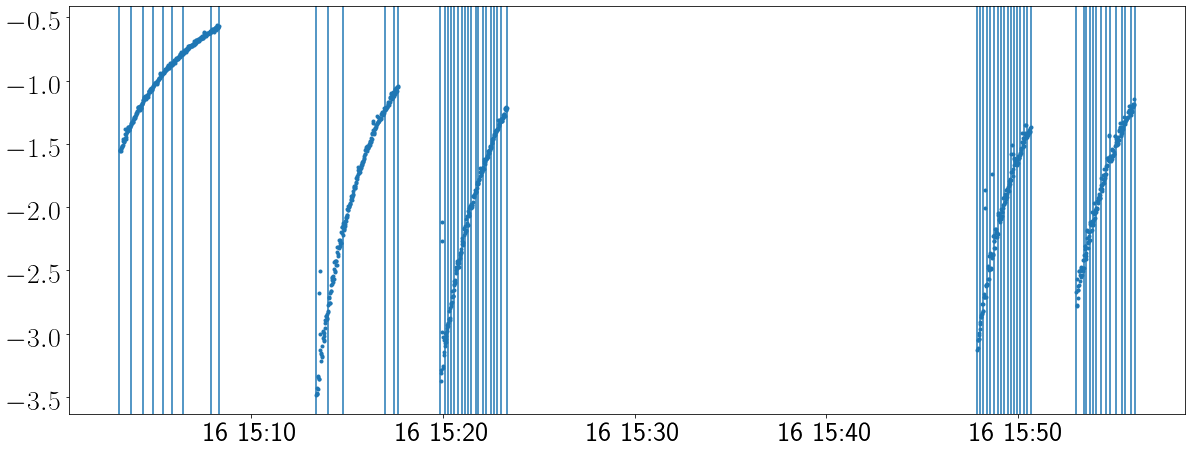

In [15]:
df = acnet_df_ROUND_LONG_with_bunch_sizes_in_time_intervals
fig, ax = plt.subplots()
ax.plot(df.index, df['N:IWCMI'],'.')
for t in res_df_ROUND_Low_RF['real_datetime']:
    ax.axvline(t)
plt.show()

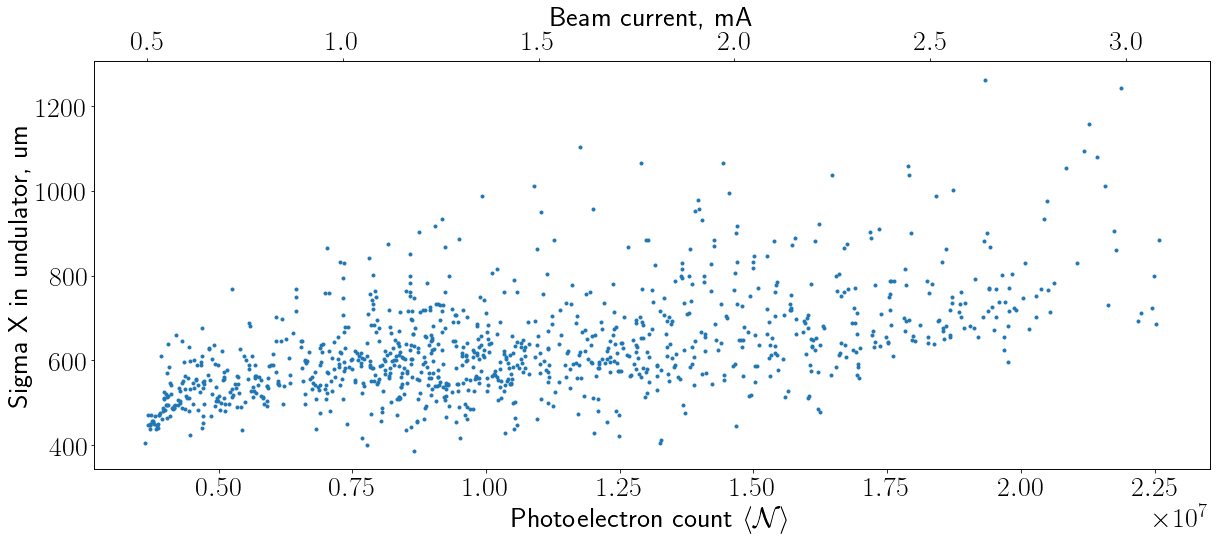

In [16]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
df = acnet_df_ROUND_LONG_with_bunch_sizes_in_time_intervals
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_X'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma X in undulator, um")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

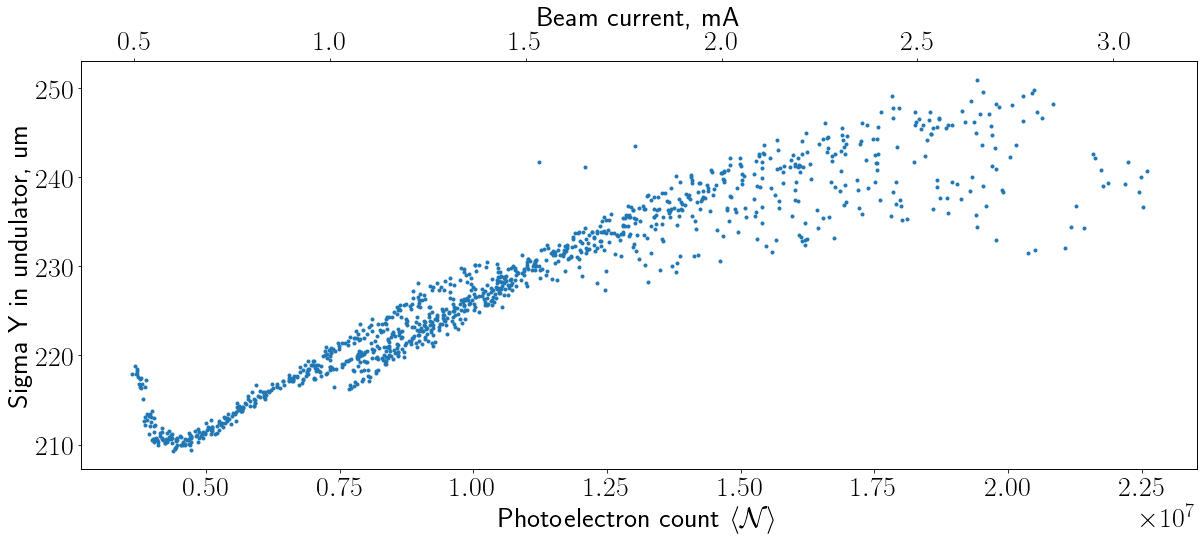

In [17]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
df = acnet_df_ROUND_LONG_with_bunch_sizes_in_time_intervals
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_Y'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma Y in undulator, um")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

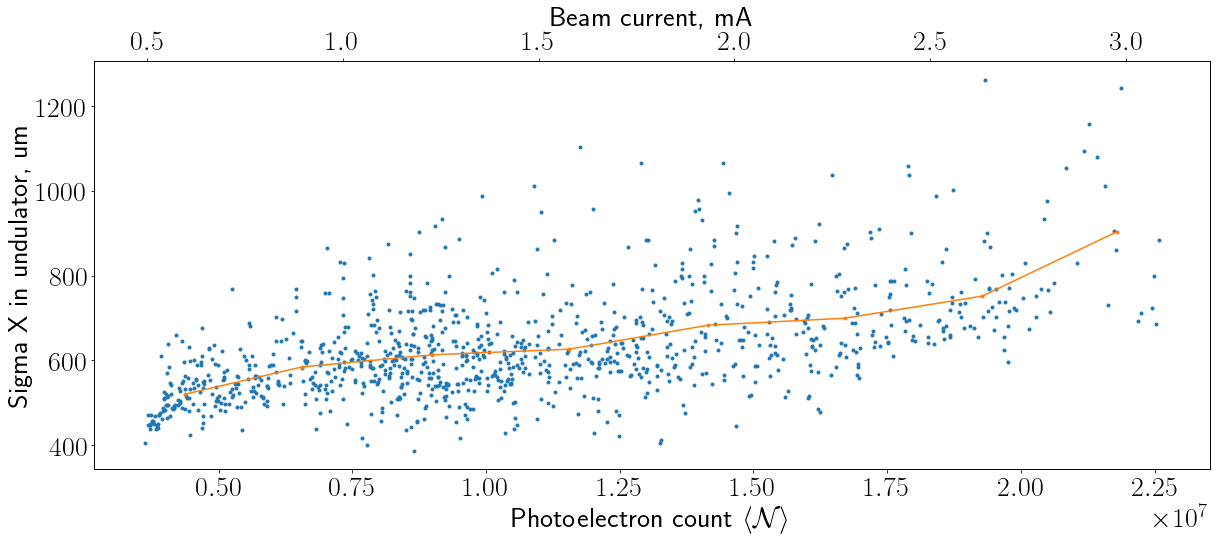

In [18]:
from matplotlib import rc
rc("text", usetex=True)
df = acnet_df_ROUND_LONG_with_bunch_sizes_in_time_intervals
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_X'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma X in undulator, um")
ax1 = ax.twiny()
dI = 0.4
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').mean()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
dfsx = df['Sigma_um_X'].values
sx_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    dfsx, bounds_error=False, fill_value=(dfsx[-1],dfsx[0]))
sx_interp = sx_func(-acnet_df_ROUND_LONG_with_bunch_sizes_in_time_intervals['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
sx_err_stat = np.nanstd(acnet_df_ROUND_LONG_with_bunch_sizes_in_time_intervals['Sigma_um_X'].values-sx_interp)
ax.plot(photoel, df['Sigma_um_X'],'.-')
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

In [19]:
sx_err_stat

100.02034685355278

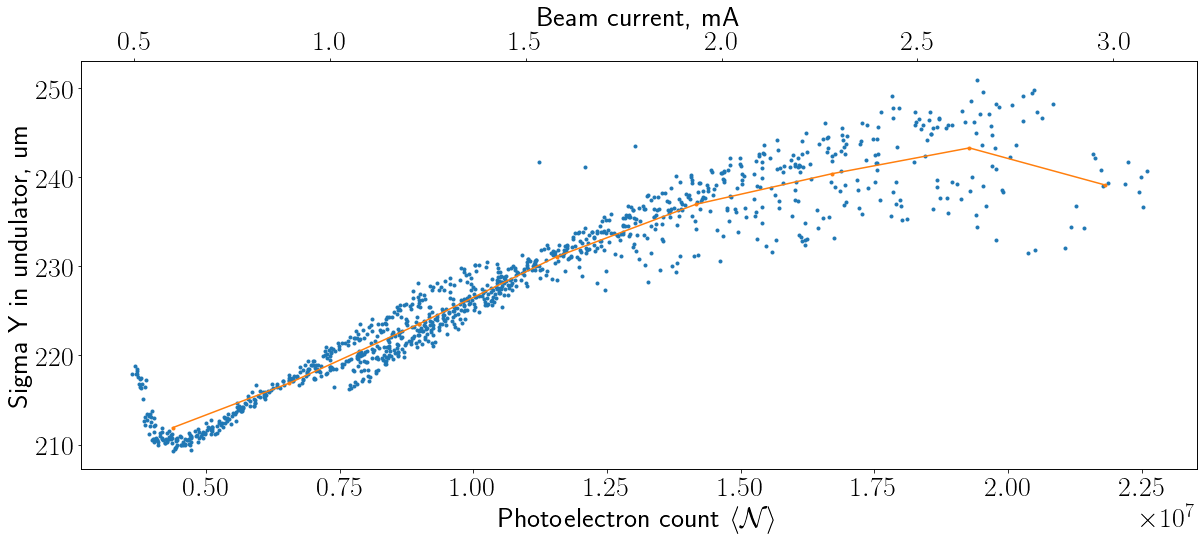

In [20]:
from matplotlib import rc
rc("text", usetex=True)
df = acnet_df_ROUND_LONG_with_bunch_sizes_in_time_intervals
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
fig, ax = plt.subplots()
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_Y'],'.')
dI = 0.4
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').mean()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
dfsy = df['Sigma_um_Y'].values
sy_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    dfsy, bounds_error=False, fill_value=(dfsy[-1],dfsy[0]))
sy_interp = sy_func(-acnet_df_ROUND_LONG_with_bunch_sizes_in_time_intervals['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
sy_err_stat = np.nanstd(acnet_df_ROUND_LONG_with_bunch_sizes_in_time_intervals['Sigma_um_Y'].values-sy_interp)
ax.plot(photoel, df['Sigma_um_Y'],'.-')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma Y in undulator, um")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

In [21]:
sy_err_stat

2.5133765388540708

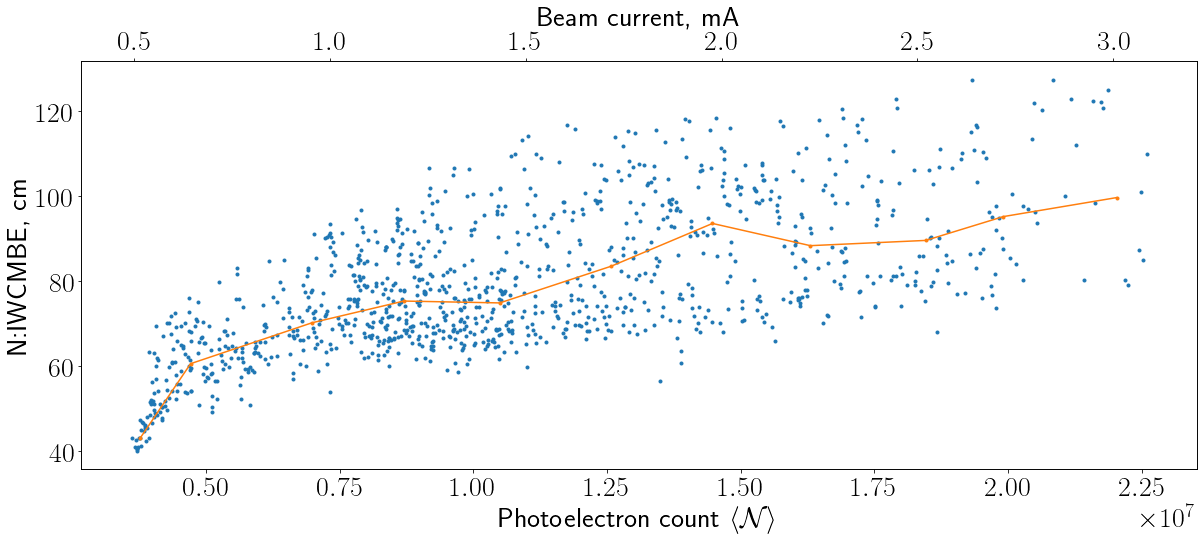

In [22]:
from matplotlib import rc
rc("text", usetex=True)
df = acnet_df_ROUND_LONG_with_bunch_sizes_in_time_intervals
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
fig, ax = plt.subplots()
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['N:IWCMBE'],'.')
dI = 0.3
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').median()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
dfsz = df['N:IWCMBE'].values
sz_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    dfsz, bounds_error=False, fill_value=(dfsz[-1],dfsz[0]))
sz_interp = sz_func(-acnet_df_ROUND_LONG_with_bunch_sizes_in_time_intervals['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
sz_err_stat = np.nanstd(acnet_df_ROUND_LONG_with_bunch_sizes_in_time_intervals['N:IWCMBE'].values-sz_interp)
ax.plot(photoel, df['N:IWCMBE'],'.-')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("N:IWCMBE, cm")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

In [23]:
sz_err_stat

11.906880062813935

In [24]:
df_desc = df.describe()
df_desc

,N:ITC1RSV,N:ITC1RSH,N:ITC2RSV,N:ITC2RSH,N:ITC3RSV,N:ITC3RSH,N:ITC4RSV,N:ITC4RSH,N:ITC4LSV,N:ITC4LSH,N:ITC3LSV,N:ITC3LSH,N:ITC2LSV,N:ITC2LSH,N:ITC1LSV,N:ITC1LSH,N:IWCMBF,N:IWCMBR,N:IWCMBP,N:IWCMI,N:IRFEPA,N:IRFEPP,N:IWCMBE,N:IWCMBM,N:IWCMBG,N:IWCMIG,N:IBEAMA,N:IRFEPC,N:IRFEAT,N:IRFEFP,N:IRFECG,N:IWCMI_recalibrated_to_IWCMI_absolute,N:IBEAM_recalibrated_to_IWCMI_absolute,Sigma_um_X,Sigma_um_X_err,Sigma_um_Y,Sigma_um_Y_err,Angle_spread_rad_X,Angle_spread_rad_Y,ex_um,ex_err,ey_um,ey_err,dp/p,dp/p_err
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.0000,1.100000e+01,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.0,11.0,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.0
mean,323.225771,150.689283,136.786345,439.511540,202.134582,684.716615,105.9989,7.327710e+02,382.370213,379.042430,192.843573,698.240964,136.440126,473.191799,397.260052,152.147662,223.635959,66.893936,-82.666289,-1.942890,75.497666,99.173405,79.453681,61.389608,84.699486,-2.032101,-1.886978,42.5,-18.0,0.405457,0.056982,-1.718611,-1.824211,638.131536,30.368430,230.689555,4.583737,0.000215,0.000311,0.036943,0.020151,0.054202,0.002151,0.000568,0.0
std,17.157659,10.587413,6.829814,45.667608,11.636209,83.297584,0.0000,1.192358e-13,16.589908,43.695055,10.633001,87.550571,7.521740,50.915264,21.756008,14.628566,58.690360,12.774121,1.572399,0.958338,0.311743,1.974287,16.860207,12.495598,19.386541,1.005761,0.916781,0.0,0.0,0.008248,0.000577,0.847712,0.886286,104.714328,6.933206,11.715435,0.186259,0.000016,0.000016,0.005330,0.007722,0.005445,0.000146,0.000108,0.0
min,295.691500,136.097050,125.773055,390.457005,183.700900,527.170015,105.9989,7.327710e+02,355.697690,324.877455,174.963900,532.374020,124.617650,419.069705,361.058590,136.049245,97.166508,41.817614,-85.370264,-3.401623,74.988717,96.924198,43.217790,34.710855,42.905266,-3.551858,-3.201029,42.5,-18.0,0.390000,0.055900,-3.008955,-3.094554,449.063887,21.624835,211.304634,4.366966,0.000192,0.000285,0.029249,0.009492,0.045369,0.001992,0.000355,0.0
25%,308.437150,141.839670,131.228045,403.341300,192.093998,641.200742,105.9989,7.327710e+02,367.700530,347.112420,184.140400,654.813752,130.003298,433.073177,378.975105,140.424230,201.435675,62.643223,-83.417660,-2.683618,75.277303,97.701813,72.544630,56.146285,76.550462,-2.795817,-2.611551,42.5,-18.0,0.400000,0.056600,-2.373833,-2.524683,593.435974,26.345883,220.417014,4.452033,0.000205,0.000297,0.033340,0.015809,0.049372,0.002020,0.000532,0.0
50%,326.292390,150.149200,138.200350,426.754820,203.413190,695.734990,105.9989,7.327710e+02,387.542935,372.254760,195.089905,703.881040,137.623500,458.802155,403.140150,148.459700,233.053774,64.064734,-82.313138,-1.942099,75.580168,98.705170,83.508780,63.915583,88.425117,-2.042387,-1.917756,42.5,-18.0,0.408102,0.057167,-1.717912,-1.853966,614.081008,26.835301,233.648831,4.526017,0.000215,0.000315,0.036552,0.016690,0.055471,0.002121,0.000544,0.0
75%,338.563881,158.758772,142.798597,468.917777,212.642564,745.815016,105.9989,7.327710e+02,396.545270,409.242299,202.421951,762.702621,143.245394,505.043039,414.180420,161.648165,261.780812,73.589523,-81.438366,-1.210602,75.749882,100.091682,91.560475,70.191336,99.111648,-1.273223,-1.188905,42.5,-18.0,0.410000,0.057300,-1.070856,-1.149358,695.018373,33.069695,240.409106,4.708411,0.000227,0.000324,0.040770,0.023311,0.058728,0.002239,0.000625,0.0
max,343.615910,167.685300,144.623200,531.105010,215.934010,795.447508,105.9989,7.327710e+02,401.475600,460.323900,204.796710,825.522030,145.496900,576.335510,422.033810,180.694145,297.390292,89.987787,-80.933851,-0.582911,75.839536,102.576753,99.635049,76.622093,108.119140,-0.578175,-0.551588,42.5,-18.0,0.420000,0.058000,-0.515622,-0.533240,829.677534,45.479259,243.805954,4.944129,0.000237,

In [25]:
hybrid_balance_error = get_from_config("HybridBalanceError")
fit_errorbar = get_from_config("varN_error_fit")

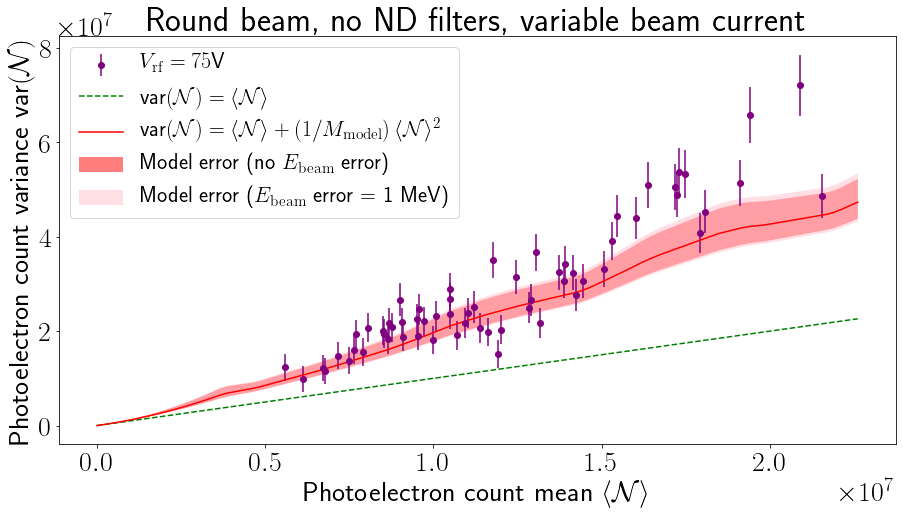

In [35]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
colors = {"ROUND": 'blue', "ROUNDLONG": 'purple'}
x_aux = np.linspace(0, ax.get_xlim()[1],100)
theor_df = pd.DataFrame({"N": x_aux})
theor_df['sx'] = sx_func(theor_df['N'])
theor_df['sy'] = sy_func(theor_df['N'])
theor_df['sz'] = sz_func(theor_df['N'])
theor_df['sx_err_stat'] = sx_err_stat
theor_df['sy_err_stat'] = sy_err_stat
theor_df['sz_err_stat'] = sz_err_stat
theor_df['sx_err_sm'] = df_desc.loc['mean', 'Sigma_um_X_err']
theor_df['sy_err_sm'] = df_desc.loc['mean', 'Sigma_um_Y_err']
theor_df['sz_err_sm'] = 0
theor_df['sx_err_tot'] = np.sqrt(theor_df['sx_err_stat']**2+theor_df['sx_err_sm']**2)
theor_df['sy_err_tot'] = np.sqrt(theor_df['sy_err_stat']**2+theor_df['sy_err_sm']**2)
theor_df['sz_err_tot'] = np.sqrt(theor_df['sz_err_stat']**2+theor_df['sz_err_sm']**2)
theor_df['M'] = theor_df.apply(lambda row: Mfunc(*(row[['sx','sy','sz']])), axis=1)
theor_df['Mxder'] = theor_df.apply(lambda row: Mxder(*(row[['sx','sy','sz']])), axis=1)
theor_df['Myder'] = theor_df.apply(lambda row: Myder(*(row[['sx','sy','sz']])), axis=1)
theor_df['Mzder'] = theor_df.apply(lambda row: Mzder(*(row[['sx','sy','sz']])), axis=1)
theor_df['Meder'] = theor_df.apply(lambda row: Meder(*(row[['sx','sy','sz']])), axis=1)
theor_df['M_err_no_Ebeam'] = np.sqrt(
    (theor_df['sx_err_tot']*theor_df['Mxder'])**2
    +(theor_df['sy_err_tot']*theor_df['Myder'])**2
    +(theor_df['sz_err_tot']*theor_df['Mzder'])**2)
Ebeam_error = get_from_config("Beam_energy_error_MeV")
theor_df['M_err_due_to_Ebeam'] = theor_df['Meder']*Ebeam_error
theor_df['M_err_with_Ebeam'] = np.sqrt(theor_df['M_err_due_to_Ebeam']**2
    + theor_df['M_err_no_Ebeam']**2)
theor_df['varN'] = var_theor(theor_df['N'], theor_df['M'])
theor_df['varN_top_no_Ebeam'] = var_theor(theor_df['N'], theor_df['M']-theor_df['M_err_no_Ebeam'])
theor_df['varN_bottom_no_Ebeam'] = var_theor(theor_df['N'], theor_df['M']+theor_df['M_err_no_Ebeam'])
theor_df['varN_top_with_Ebeam'] = var_theor(theor_df['N'], theor_df['M']-theor_df['M_err_with_Ebeam'])
theor_df['varN_bottom_with_Ebeam'] = var_theor(theor_df['N'], theor_df['M']+theor_df['M_err_with_Ebeam'])
fig, ax = plt.subplots(figsize=(15, 7.5))
res_df_ROUND_Low_RF = res_df_ROUND_Low_RF[res_df_ROUND_Low_RF["N"]>0.1e7]
hybrid_errorbar = 2*hybrid_balance_error*np.absolute(res_df_ROUND_Low_RF['varN'])
error_bar = np.sqrt(hybrid_errorbar**2+fit_errorbar**2)
res_df_ROUND_Low_RF['errorbar'] = error_bar
ax.errorbar(res_df_ROUND_Low_RF['N'],res_df_ROUND_Low_RF['varN'],marker='o',linestyle='None',yerr=error_bar,color='purple', label = r'$V_{\mathrm{rf}}=75$V')
ax.plot(x_aux, x_aux,color='green',linestyle='--',label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.plot(theor_df['N'], theor_df['varN'], color='red', label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle+\left(1/M_{\mathrm{model}}\right)\langle\mathcal{N}\rangle^2$")
ax.fill_between(
    theor_df['N'],
    theor_df['varN_bottom_no_Ebeam'],
    theor_df['varN_top_no_Ebeam'],
    facecolor='red', alpha=0.5, label='Model error (no $E_{\mathrm{beam}}$ error)')
ax.fill_between(
    theor_df['N'],
    theor_df['varN_bottom_with_Ebeam'],
    theor_df['varN_top_with_Ebeam'],
    facecolor='pink', alpha=0.5, label='Model error ($E_{\mathrm{beam}}$ error = 1 MeV)')
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
ax.set_title(r"Round beam, no ND filters, variable beam current")
handles, labels = plt.gca().get_legend_handles_labels()
order = [4,0,1,2,3]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.show()

In [36]:
res_df_ROUND_Low_RF.loc[:,['N', 'varN', 'errorbar']].to_csv('meas_ROUND_LONG.csv')

In [37]:
theor_df.to_csv('theor_df_ROUND_LONG.csv')

In [38]:
theor_df

,N,sx,sy,sz,sx_err_stat,sy_err_stat,sz_err_stat,sx_err_sm,sy_err_sm,sz_err_sm,sx_err_tot,sy_err_tot,sz_err_tot,M,Mxder,Myder,Mzder,Meder,M_err_no_Ebeam,M_err_due_to_Ebeam,M_err_with_Ebeam,varN,varN_top_no_Ebeam,varN_bottom_no_Ebeam,varN_top_with_Ebeam,varN_bottom_with_Ebeam
0,0.000000e+00,520.223102,211.887218,43.217790,100.020347,2.513377,11.90688,30.36843,4.583737,0,104.528997,5.227591,11.90688,4.792635e+06,8749.784455,17159.250450,110894.964841,5.296240e+05,1.608739e+06,5.296240e+05,1.693677e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,2.284512e+05,520.223102,211.887218,43.217790,100.020347,2.513377,11.90688,30.36843,4.583737,0,104.528997,5.227591,11.90688,4.792635e+06,8749.784455,17159.250450,110894.964841,5.296240e+05,1.608739e+06,5.296240e+05,1.693677e+06,2.393408e+05,2.448430e+05,2.366041e+05,2.452923e+05,2.364973e+05
2,4.569023e+05,520.223102,211.887218,43.217790,100.020347,2.513377,11.90688,30.36843,4.583737,0,104.528997,5.227591,11.90688,4.792635e+06,8749.784455,17159.250450,110894.964841,5.296240e+05,1.608739e+06,5.296240e+05,1.693677e+06,5.004608e+05,5.224697e+05,4.895141e+05,5.242668e+05,4.890870e+05
3,6.853535e+05,520.223102,211.887218,43.217790,100.020347,2.513377,11.90688,30.36843,4.583737,0,104.528997,5.227591,11.90688,4.792635e+06,8749.784455,17159.250450,110894.964841,5.296240e+05,1.608739e+06,5.296240e+05,1.693677e+06,7.833600e+05,8.328801e+05,7.587299e+05,8.369236e+05,7.577690e+05
4,9.138047e+05,520.223102,211.887218,43.217790,100.020347,2.513377,11.90688,30.36843,4.583737,0,104.528997,5.227591,11.90688,4.792635e+06,8749.784455,17159.250450,110894.964841,5.296240e+05,1.608739e+06,5.296240e+05,1.693677e+06,1.088038e+06,1.176074e+06,1.044252e+06,1.183263e+06,1.042543e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.170286e+07,897.637063,239.316881,98.939985,100.020347,2.513377,11.90688,30.36843,4.583737,0,104.528997,5.227591,11.90688,2.043077e+07,22326.379707,66913.015959,206496.622315,2.211923e+06,3.407949e+06,2.211923e+06,4.062847e+06,4.475702e+07,4.937243e+07,4.146123e+07,5.047952e+07,4.093294e+07
96,2.193131e+07,903.838854,239.148215,99.421332,100.020347,2.513377,11.90688,30.36843,4.583737,0,104.528997,5.227591,11.90688,2.065791e+07,22425.391572,67687.811080,207781.422901,2.236676e+06,3.426492e+06,2.236676e+06,4.091890e+06,4.521453e+07,4.984443e+07,4.190202e+07,5.096560e+07,4.136511e+07
97,2.215976e+07,903.838854,239.148215,99.635049,100.020347,2.513377,11.90688,30.36843,4.583737,0,104.528997,5.227591,11.90688,2.070231e+07,22473.597308,67833.313142,207781.422901,2.241484e+06,3.430019e+06,2.241484e+06,4.097473e+06,4.587958e+07,5.058999e+07,4.250820e+07,5.173278e+07,4.196055e+07
98,2.238822e+07,903.838854,239.148215,99.635049,100.020347,2.513377,11.90688,30.36843,4.583737,0,104.528997,5.227591,11.90688,2.070231e+07,22473.597308,67833.313142,207781.422901,2.241484e+06,3.430019e+06,2.241484e+06,4.097473e+06,4.659963e+07,5.140765e+07,4.315837e+07,5.257412e+07,4.259937e+07
